In [68]:
#from rock_utility import *
#import rock_utility
#print(dir(rock_utility))
import sys

def plot_board(obstacle, beliefState, agent, N, file = sys.stdout):

  from matplotlib import pyplot as plt
  fig, ax = plt.subplots(figsize = (N,N))
  ax.xaxis.set_ticks_position('top')   #将X坐标轴移到上面
  ax.invert_yaxis()  
  #
  x = [i for i in range(N)]
  y = [i for i in range(N)]
  plt.xlim((0,N))
  #plt.ylim((0,N))
  ax.set_ylim(bottom=N, top=0)  # 此处将原点设置为左上角  
  plt.xticks([0.5 + i for i in range(N )], labels = [str(i) for i in range(N)])
  plt.yticks([0.5 + i for i in range(N)], labels = [str(i) for i in range(N)])
  plt.xlabel('X Axis')
  plt.ylabel('Y Axis')
  width = 1
  height =1 

  for left, bottom in obstacle:
    rect = plt.Rectangle((left, bottom), width, height, facecolor="red", alpha = 1)
    ax.add_patch(rect)

  for left, bottom in beliefState:
    rect = plt.Rectangle((left, bottom), width, height, facecolor="blue", alpha = 0.5)
    ax.add_patch(rect)

  #plt.scatter(agent[0] + 0.5, agent[1] +0.5)
  for i in range(N):
    plt.hlines(i, 0, N , alpha = 0.5)
    plt.vlines(i, 0, N , alpha = 0.5)
  plt.grid(False)
  plt.show()


def move(belief, action, file = sys.stdout):
  result = set()
  for x, y in belief:
    for slip in [1, 2]:
      if action == "w":
        nx, ny = max(0, x - slip) , y
      if action == 'e':
        nx, ny = min(N - 1, x + slip), y
      if action == 'n':
        nx, ny = x, max(0, y - slip)
      if action == 's':
        nx, ny = x, min(N - 1, y + slip)
      result.add((nx, ny))
  return list(result)

def in_bound(obstacle, lx, ly, rx, ry, file = sys.stdout):
  x, y = obstacle[0], obstacle[1]
  return lx <= x <= rx and ly <= y <= ry

def preamble(R, obstacles, lx, ly, rx, ry, file = sys.stdout):
  print("pomdp", file = file)
  print("observables", file = file)
  observables = ["started"]
  for i in range(1, R + 1):
    if not in_bound(obstacles[i - 1], lx, ly, rx, ry):
      continue
    observables.append("r{}taken".format(i))
    observables.append("r{}lastobs".format(i))
  observables.append("done")
  print(", ".join(observables), file = file)
  print("endobservables", file = file)

def grid(N="", file = sys.stdout):
  if N:
    print("const int N={};".format(N), file = file)
  else:
    print("const int N;", file = file)
  print("const int xMAX = N-1;", file = file)
  print("const int yMAX = N-1;", file = file)
  print("const int xMIN = 0;", file = file)
  print("const int yMIN = 0;", file = file)
  print("const double slippery = 0.1;", file = file)
  print("// How likely is a rock a good rock", file = file)
  print("const double goodrock = 0.5;", file = file)

def primary_grid(lx, ly, rx, ry, file = sys.stdout):
  print("const int primaryMinX = {};".format(lx), file = file)
  print("const int primaryMinY = {};".format(ly), file = file)
  print("const int primaryMaxX = {};".format(rx), file = file)
  print("const int primaryMaxY = {};".format(ry), file = file)
  print("const int borderSize = 2;", file = file)
  print("const int areaMinX = max(primaryMinX - borderSize, xMIN);", file = file)
  print("const int areaMinY = max(primaryMinY - borderSize, yMIN);", file = file)
  print("const int areaMaxX = min(primaryMaxX + borderSize, xMAX);", file = file)
  print("const int areaMaxY = min(primaryMaxY + borderSize, yMAX);", file = file)

def rock_positions(obstacles, lx, ly, rx, ry, file = sys.stdout):
  for i, (x, y) in enumerate(obstacles):
    #if not in_bound((x, y), lx, ly, rx, ry):
      #continue
    print("const r{}x = {};".format(i + 1, x), file = file)
    print("const r{}y = {};".format(i + 1, y), file = file)
def constants(obstacles, lx, ly, rx, ry, file = sys.stdout, N = ""):
  grid(N, file)
  primary_grid(lx, ly, rx, ry, file)
  rock_positions(obstacles, lx, ly, rx, ry, file)


def formula_finish(is_main, file = sys.stdout):
  print("// We are done when we reach max x location", file = file)
  if is_main:
    print("formula finish = started & x = xMAX;", file = file)
  else:
    string = "formula finish = started & (!bad) & (x = xMAX | ";
    out_primary_bound = "x = primaryMinX - 1 | x = primaryMinX - 2| y = primaryMinY - 1 | y = primaryMinY - 2 | "
    out_primary_bound += "x = primaryMaxX + 1 | x = primaryMaxX + 2| y = primaryMaxY + 1 | y = primaryMaxY + 2);"
    print(string + out_primary_bound, file = file)

def observable_finish(file = sys.stdout):
  print("observable \"seefinish\" = finish;", file = file)
def formula_maxdist(file = sys.stdout):
  print("formula maxdist = xMAX-xMIN+yMAX-yMIN;", file = file)

def formula_dist(R, obstacles, lx, ly, rx, ry, file = sys.stdout):
  for i in range(1, R + 1):
    #if not in_bound(obstacles[i - 1], lx, ly, rx, ry):
      #continue
    print("formula r{}dist = max(r{}x-x,x-r{}x) + max(r{}y-y,y-r{}y);".format(i, i, i, i, i), file = file)
  
def formula_good(is_main, R, obstacles, lx, ly, rx, ry, file = sys.stdout, reach_good = False):
  print("// Currently we are not setting extra requirement for reaching good", file = file)
  if not reach_good:
    print("formula good = finish & done;", file = file)
    return

  if not is_main:
    print("formula good = finish & done;", file = file)
    return

  prefix = "formula good = finish & done & ("
  ending = ");"
  qual = []
  taken = []
  for i in range(1, R + 1):
    if not in_bound(obstacles[i - 1], lx, ly, rx, ry):
      continue
    qual.append("!r{}qual".format(i))
    taken.append("r{}taken".format(i))
  prefix += "(" + " & ".join(qual) + ") | (" + " | ".join(taken) + ")" + ending
  print(prefix, file = file)

def formula_bad(R, obstacles, lx, ly, rx, ry, file = sys.stdout):
  print("//not sure if to include the rocks on the border... currently do not consider them", file = file)
  prefix = "formula bad = "
  ending  = ";"
  bad = []
  for i in range(1, R + 1):
    if not in_bound(obstacles[i - 1], lx, ly, rx, ry):
      continue
    bad.append("(r{}dist=0 & !r{}qual)".format(i, i))
  if len(bad) > 0:
    prefix += " | ".join(bad) + ending
  else:
    prefix += "false" + ending;
  print(prefix, file = file)

def observable_at(R, obstacles, lx, ly, rx, ry, file = sys.stdout):
  for i in range(1, R + 1):
    if not in_bound(obstacles[i - 1], lx, ly, rx, ry):
      continue
    print("observable \"atr{}\" = r{}dist <= 0;".format(i, i), file = file)
def observable_near(R, obstacles, lx, ly, rx, ry, file = sys.stdout):
  for i in range(1, R + 1):
    if not in_bound(obstacles[i - 1], lx, ly, rx, ry):
      continue
    print("observable \"nearr{}\" = r{}dist <= 1;".format(i, i), file = file)

def formula_normdist(R, obstacles, lx, ly, rx, ry, file = sys.stdout):
  for i in range(1, R + 1):
    if not in_bound(obstacles[i - 1], lx, ly, rx, ry):
      continue
    print("formula normdistr{} = (r{}dist <= 1) ? 1 : 2; // min(1+((r{}dist-1)/maxdist), 1.0)".format(i, i, i), file = file)

def observable_good_bad(file = sys.stdout):
  print("observable \"seebad\" = bad;", file = file)
  print("observable \"seegood\" = good;", file = file)

def formula_observable(R, is_main, obstacles, lx, ly, rx, ry, file = sys.stdout):
  formula_finish(is_main, file)
  observable_finish(file)
  formula_maxdist(file)
  formula_good(is_main, R, obstacles, lx, ly, rx, ry, file)
  formula_dist(R, obstacles, lx, ly, rx, ry, file)
  formula_bad(R, obstacles, lx, ly, rx, ry, file)
  formula_normdist(R, obstacles, lx, ly, rx, ry, file)
  observable_at(R, obstacles, lx, ly, rx, ry, file)
  observable_near(R, obstacles, lx, ly, rx, ry, file)
  observable_good_bad(file)

def master(file = sys.stdout):
  print("module master", file = file)
  print("started : bool init false;", file = file)
  print("done : bool init false;", file = file)
  print("", file = file)
  print("[placement] !started -> (started\'=true);", file = file)
  print("[north] started & !done -> true;", file = file)
  print("[south] started  & !done -> true;", file = file)
  print("[east] started  & !done-> true;", file = file)
  print("[west] started & !done -> true;", file = file)
  print("[finish] finish | done -> (done\'=true);", file = file)
  print("endmodule", file = file)
def robot(file = sys.stdout):
  print("module robot", file = file)
  print("x : [areaMinX..areaMaxX] init primaryMinX;", file = file)
  print("y : [areaMinY..areaMaxX] init primaryMinY;", file = file)
  print("", file = file)
  print("[west] true -> (1-slippery): (x\'=max(x-1,areaMinX)) + slippery: (x\'=max(x-2,areaMinX));", file = file)
  print("[east] true -> (1-slippery): (x\'=min(x+1,areaMaxX)) + slippery: (x\'=min(x+2,areaMaxX));", file = file)
  print("[south]  true -> (1-slippery): (y\'=min(y+1,areaMaxY)) + slippery: (y\'=min(y+2,areaMaxY));", file = file)
  print("[north]  true -> (1-slippery): (y\'=max(y-1,areaMinY)) + slippery: (y\'=max(y-2,areaMinY));", file = file)
  print("endmodule", file = file)

def one_rock(k, file = sys.stdout):
  rk = "r" + str(k)
  print("module rock1".replace("1", str(k)), file = file)
  print("r1qual : bool init false;".replace("r1", rk), file = file)
  print("r1taken : bool init false;".replace("r1", rk), file = file)
  print("r1lastobs : bool init false;".replace("r1", rk), file = file)
  print("[placement] true -> goodrock : (r1qual'=true) + (1-goodrock) : (r1qual'=false);".replace("r1", rk), file = file)
  print("".replace("r1", rk), file = file)
  print("[r1sample] r1dist = 0 & started & !done & !bad & !finish & !r1taken-> 1:(r1taken'=(x = r1x & y = r1y & !r1taken));".replace("r1", rk), file = file)
  print("[r1sample] r1dist = 0 & started & !done & !bad & !finish & r1taken -> true;".replace("r1", rk), file = file)
  print("".replace("r1", rk), file = file)
  print("[r1sense] started & !r1taken & !done & !bad & !finish -> (1/normdistr1): (r1lastobs'=r1qual) +  (1-(1/normdistr1)): (r1lastobs'=!r1qual);".replace("r1", rk), file = file)
  print("[north] true -> (r1lastobs'=false);".replace("r1", rk), file = file)
  print("[south] true -> (r1lastobs'=false);".replace("r1", rk), file = file)
  print("[east] true -> (r1lastobs'=false);".replace("r1", rk), file = file)
  print("[west] true -> (r1lastobs'=false);".replace("r1", rk), file = file)
  print("endmodule".replace("r1", rk), file = file)
    
def rocks(R, obstacles, lx, ly, rx, ry, file = sys.stdout):
  for i in range(1, R + 1):
    if not in_bound(obstacles[i - 1], lx, ly, rx, ry):
      continue
    one_rock(i, file)



def reward(R, obstacles, lx, ly, rx, ry, finishGood = 100, finish = 20, file = sys.stdout):
  print("rewards \"rew\"", file = file)
  sampleGood = 100
  for i in range(1, R + 1):
    if not in_bound(obstacles[i - 1], lx, ly, rx, ry):
      continue
    print("[r{}sample] r{}qual & !r{}taken : {};".format(i, i, i, sampleGood), file = file)
  
  prefix = "[finish] ("
  ending = "): {};".format(finishGood) ;
  qual = []
  taken = []
  for i in range(1, R + 1):
    if not in_bound(obstacles[i - 1], lx, ly, rx, ry):
      continue
    qual.append("!r{}qual".format(i))
    taken.append("r{}taken".format(i))
  if len(qual) > 0:
    prefix += "(" + " & ".join(qual) + ") | (" + " | ".join(taken) + ")" + ending
    print(prefix, file = file)

  print("[finish] true: {};".format(finish), file = file)
  print("endrewards", file = file)

def cost(R, obstacles, lx, ly, rx, ry, finishBad = 100, bad = 20, file = sys.stdout):
  
  print("rewards \"cos\"", file = file)
  print("//[r1sample] !r1qual & !r1taken : 10; // no need; cause it won\'t r1sample is not enabled if !r1qual", file = file)
  print("//[r2sample] !r2qual & !r1taken: 10; // no need; cause it won\'t r1sample is not enabled if !r1qual", file = file)
  print("//[r1sample] r1taken : 20;", file = file)
  print("//[r2sample] r2taken : 20;", file = file)
  finishBad = 100
  prefix = "[finish] !("
  ending = "): {};".format(finishBad) ;
  qual = []
  taken = []
  for i in range(1, R + 1):
    if not in_bound(obstacles[i - 1], lx, ly, rx, ry):
      continue
    qual.append("!r{}qual".format(i))
    taken.append("r{}taken".format(i))
  if len(qual) > 0:
    prefix += "(" + " & ".join(qual) + ") | (" + " | ".join(taken) + ")" + ending
    print(prefix, file = file)
  

  print("bad:{};".format(20), file = file)
  print("[east] true: 1;", file = file)
  print("[west] true: 1;", file = file)
  print("[north] true: 1;", file = file)
  print("[south] true: 1;", file = file)
  for i in range(1, R + 1):
    if not in_bound(obstacles[i - 1], lx, ly, rx, ry):
      continue
    print("[r{}sense] true: 1;".format(i), file = file)
    
  for i in range(1, R + 1):
    if not in_bound(obstacles[i - 1], lx, ly, rx, ry):
      continue
    print("[r{}sample] true: 1;".format(i), file = file)
  print("endrewards", file = file)
def cost_2(file = sys.stdout):
  print("rewards \"cost\"", file = file)
  print("[r1sense] true : 1;", file = file)
  print("[r1sample] !r1qual : 20;", file = file)
  print("[r2sense] true : 1;", file = file)
  print("[r2sample] !r2qual : 20;", file = file)
  print("//[r3sense] true : 1;", file = file)
  print("//[r3sample] !r3qual : 20;", file = file)
  print("[north] true : 1;", file = file)
  print("[south] true : 1;", file = file)
  print("[west] true : 1;", file = file)
  print("[east] true : 1;", file = file)
  print("[finish] true : (!r1taken & r1qual ? 30 : 0) + (!r2taken & r2qual ? 30 : 0) ;//+ (!r3taken & r3qual ? 30 : 0) ;", file = file)
  print("endrewards", file = file)

def reward_cost(R, obstacles, lx, ly, rx, ry, file = sys.stdout):
  reward(R, obstacles, lx, ly, rx, ry, file = file)
  cost(R, obstacles, lx, ly, rx, ry, file = file)
    
def labels(R, obstacles, lx, ly, rx, ry, file = sys.stdout):
  print("label \"notbad\" = !bad;", file = file)
  print("label \"goal\" = good;", file = file)
  prefix = "label \"rockposition\" = "
  ending = ";"
  position = []
  for i in range(1, R + 1):
    if not in_bound(obstacles[i - 1], lx, ly, rx, ry):
      continue
    position.append("(!r{}taken & r{}x = x & r{}y = y)".format(i, i, i))
  #if len(position) > 0:
  #  print(prefix + " | ".join(position) + ending, file = file)

def generate_rock_file(N, R, is_main, lx, ly, rx, ry, file):
  obstacles = generate_rocks(N, R, file)
  preamble(R, obstacles, lx, ly, rx, ry, file)
  constants(obstacles, lx, ly, rx, ry, file, N)
  formula_observable(R, is_main, obstacles, lx, ly, rx, ry, file)
  master(file)
  robot(file)
  rocks(R, obstacles, lx, ly, rx, ry, file)
  labels(R, obstacles, lx, ly, rx, ry, file)
  reward_cost(R, obstacles, lx, ly, rx, ry, file)



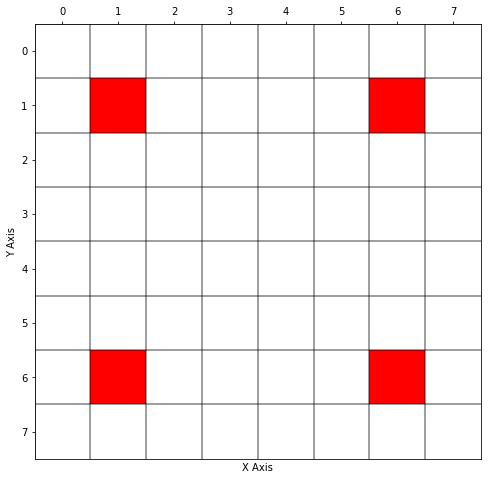

Help on function plot_board in module __main__:

plot_board(obstacle, beliefState, agent, N, file=<ipykernel.iostream.OutStream object at 0x0000000004D49358>)



In [74]:
# generate_rock_file(N, R, is_main, primaryMinX, primaryMinY, primaryMaxX, primaryMaxY, file = sys.stdout):
def generate_rocks(N, R, file = sys.stdout):
  obstacles = set()
  import random
  random.seed(N)
  while len(obstacles) < R:
    obstacle = (random.randint(0, N - 1), random.randint(0, N - 1))
    if obstacle == (0, 0):
      continue
    obstacles.add(obstacle)
  if N == 7:
    obstacles = [(1, 1), (1, 2), (2, 1), (3, 3), (3, 5), (4, 0), (4, 1), (6, 4)]
  if N == 8 and R == 4:
    obstacles = [(1,1), (1,6), (6,1), (6,6)]
  if N == 8 and R == 5:
    obstacles = [(1,1), (1,6), (6,1), (6,6), (4,0), (3,7)]
  if N == 8 and R == 6:
    obstacles = [(1,1), (1,6), (6,1), (6,6), (4,0), (3,7)]
      
  if N == 10 and R == 4:
    obstacles = [(1,1), (7,2), (1, 8), (8, 7)]
  if N == 10 and R == 6:
    obstacles = [(1, 2), (2, 0), (8, 7), (2, 8), (7, 4), (7, 1)]
  #print("estimated states " + str(N * N * (3 ** R)), file = file)
  #plot_board(obstacles, [], None, N)
  return sorted(list(obstacles))


import os
N = 8; R = 4
shieldSize = N // 2
shieldSizeX = shieldSize
shieldSizeY = shieldSize   
xMIN = yMIN = 0
xMAX = N - 1
yMAX = N - 1
borderSize = 2

is_main = False
import os
for primaryMinX in range(0, xMAX, shieldSizeX):
  for primaryMinY in range(0, yMAX, shieldSizeY):
    primaryMaxX, primaryMaxY = primaryMinX + shieldSizeX - 1, primaryMinY + shieldSizeY - 1
    areaMinX = max(primaryMinX - borderSize, xMIN)
    areaMinY = max(primaryMinY - borderSize, yMIN)
    areaMaxX = min(primaryMaxX + borderSize, xMAX)
    areaMaxY = min(primaryMaxY + borderSize, yMAX)
    
    lx, ly, rx, ry = areaMinX, areaMinY, areaMaxX, areaMaxY
    #lx, ly, rx, ry = primaryMinX, primaryMinY, primaryMaxX, primaryMaxY,
    file_path = "./N{}R{}/".format(N, R)
    winning_path = file_path + "winningregion/"
    log_path = file_path + "log/"
    for p in [file_path, winning_path, log_path]:
        if not os.path.exists(p):
            os.makedirs(p)
    
    file_name = file_path + "rocks_N{}R{}_factored-{}-{}-{}-{}-{}.nm".format(N, R, shieldSize, primaryMinX, primaryMinY, primaryMaxX, primaryMaxY)

    with open(file_name, 'w') as file:
      generate_rock_file(N, R, is_main, areaMinX, areaMinY, areaMaxX, areaMaxY, file = file)
      obstacles = generate_rocks(N, R, file)
    file.close()

with open(file_path + "rocks_N{}R{}_centralized.nm".format(N, R), 'w') as file:
    generate_rock_file(N, R, True, 0, 0, N - 1, N - 1, file = file)
file.close()

obstacles = generate_rocks(N,R)
plot_board(obstacles, [], None, N)
help(plot_board)